In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # Disable GPU

import jax
import jax.numpy as jnp
import jax.tree_util as jtu

import optax
import jaxopt

import matplotlib.pyplot as plt

from gpax.core import Parameter, set_default_jitter
from gpax.models import ExactGPRegression, SparseGPRegression
from gpax.kernels import RBF
from gpax.means import Scalar, Average
from gpax.likelihoods import Gaussian
from gpax.utils import train_fn
from gpax.plotting import plot_posterior

import pprint
pp = pprint.PrettyPrinter(depth=4)

is_parameter = lambda x: isinstance(x, Parameter)

# set_default_jitter(1e-3)

2022-12-22 16:44:36.494549: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


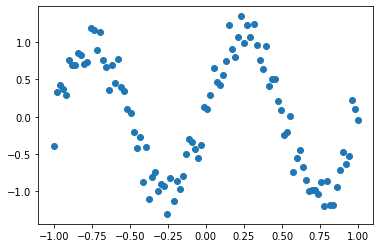

In [2]:
X = jnp.linspace(-1, 1, 100).reshape(-1, 1)
key = jax.random.PRNGKey(0)
y = jnp.sin(2 * jnp.pi * X) + jax.random.normal(key, X.shape)*0.2
y = y.ravel()

plt.scatter(X, y);

## GP

In [3]:
print(X[::10].shape)
model = SparseGPRegression(kernel=RBF(X), likelihood=Gaussian(), mean=Scalar(), X_inducing=X[::10])

init_key = jax.random.PRNGKey(1)
raw_params = model.initialize(init_key)

(10, 1)


In [4]:
raw_params

{'X_inducing': DeviceArray([[-1.        ],
              [-0.79797983],
              [-0.59595954],
              [-0.39393938],
              [-0.19191921],
              [ 0.01010099],
              [ 0.21212122],
              [ 0.41414142],
              [ 0.6161616 ],
              [ 0.8181819 ]], dtype=float32),
 'kernel': {'lengthscale': DeviceArray([-0.27225718], dtype=float32),
  'scale': DeviceArray(-0.8674116, dtype=float32)},
 'likelihood': {'scale': DeviceArray(0.8126043, dtype=float32)},
 'mean': {'value': DeviceArray(1.4171388, dtype=float32)}}

In [5]:
params = model.get_parameters()
pp.pprint(params)

{'X_inducing': DeviceArray([[-1.        ],
             [-0.79797983],
             [-0.59595954],
             [-0.39393938],
             [-0.19191921],
             [ 0.01010099],
             [ 0.21212122],
             [ 0.41414142],
             [ 0.6161616 ],
             [ 0.8181819 ]], dtype=float32),
 'kernel': {'lengthscale': DeviceArray([0.5662557], dtype=float32),
            'scale': DeviceArray(0.3506832, dtype=float32)},
 'likelihood': {'scale': DeviceArray(1.1798143, dtype=float32)},
 'mean': {'value': DeviceArray(1.4171388, dtype=float32)}}


In [6]:
params_objects = model.get_parameters(raw_dict=False)
bijectors = jtu.tree_map(lambda x: type(x.bijector).__name__, params_objects, is_leaf=is_parameter)
pp.pprint(bijectors)

{'X_inducing': 'Identity',
 'kernel': {'lengthscale': 'Softplus', 'scale': 'Softplus'},
 'likelihood': {'scale': 'Softplus'},
 'mean': {'value': 'Identity'}}


In [7]:
def loss_fun(raw_params):
    model.set_raw_parameters(raw_params)
    return -model.log_probability(X, y)

loss_fun(raw_params)

DeviceArray(141.41544, dtype=float32)

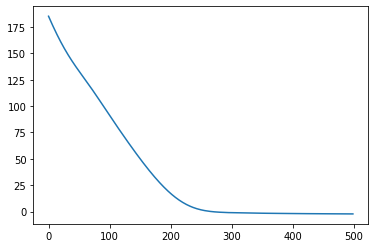

In [8]:
model = SparseGPRegression(kernel=RBF(X), likelihood=Gaussian(), mean=Scalar(), X_inducing=X[::10])
optimizer = optax.adam(learning_rate=0.01)
n_iters = 500

init_key = jax.random.PRNGKey(42)
raw_params = model.initialize(init_key)

result = train_fn(loss_fun, raw_params, optimizer, n_iters=n_iters)

plt.plot(result["loss_history"]);

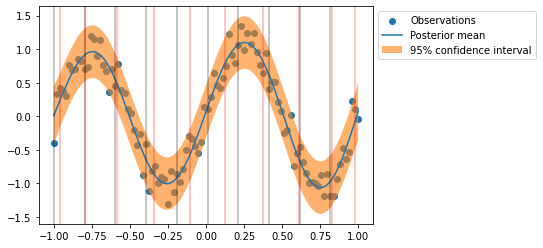

In [9]:
X_test = jnp.linspace(-1, 1, 200).reshape(-1, 1)
model.set_raw_parameters(result["raw_params"])
pred_mean, pred_cov = model.predict(X, y, X_test)

ax = plot_posterior(X, y, X_test, pred_mean, pred_cov, ax=None, alpha=0.6);
ax.legend(bbox_to_anchor=(1,1));
for x in X[::10]:
    ax.axvline(x, color="k", alpha=0.3)
    
for x in model.X_inducing():
    ax.axvline(x, color="r", alpha=0.3)